# Fit conic to real data from proplyd arcs (second proplyd)

We will use the same data that we used in Tarango Yong & Henney (2018) to demonstrate the circle-fit algorithm. This started off identical to demo04, except for the data file. But it quickly takes a very different turn, due to the best fit being an lowish-eccentricity ellipse rather than a hyperbola.

It turns out that the residual function prefers to fit the data points to the "back" side of the ellipse (the side away from the focus). This means that the orientation of the ellipse axis gets flipped.



## Imports

In [1]:
import time

In [2]:
start_time = time.time()
from pathlib import Path
import sys
import confitti
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns
import regions as rg
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [3]:
sns.set_context("notebook", font_scale=1.2)

## Set up the arc data

In [4]:
datapath = Path.cwd().parent / "data"
figpath = Path.cwd().parent / "figs"
saveprefix = "demo04"

### Read arc points in celestial coordinates from DS9-format regions file

This function is copied over from the circle-fit project with some updates to reflect more recent API changes. Note that older versions of the regions library require `marker_string="point"`

In [5]:
def read_arc_data_ds9(filename, pt_star="o", pt_arc="x", marker_string="marker"):
    """
    Return the sky coordinates of a star (single point of type
    `pt_star`) and arc (multiple points of type: `pt_arc`), which are
    read from the DS9 region file `filename`
    """
    regions = rg.Regions.read(filename)

    try:
        (star,) = [x for x in regions if x.visual[marker_string] == pt_star]
    except IndexError:
        sys.exit("One and only one 'circle' region is required")
    points = [x for x in regions if x.visual[marker_string] == pt_arc]
    return star, points

In [6]:
star, points = read_arc_data_ds9(datapath / "new-w000-400-ridge.reg")

In [7]:
star.center

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (83.74819167, -5.40003889)>

### Convert to Cartesian x, y pixel coordinates

We use a WCS transformation to put the arc in simple x, y coordinates so we do not need to worry about any astro stuff for a while. We could get the WCS from a fits image header, but instead we will just construct a grid centered on the star with 0.1 arcsec pixels.


In [8]:
w = WCS(naxis=2)
w.wcs.crpix = [0, 0]
w.wcs.cdelt = np.array([-0.1, 0.1]) / 3600
w.wcs.crval = [star.center.ra.deg, star.center.dec.deg]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 83.74819166666666 -5.400038888888889 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -2.777777777777778e-05 2.777777777777778e-05 
NAXIS : 0  0

In [9]:
xpts, ypts = SkyCoord([point.center for point in points]).to_pixel(w)

## Plot the points

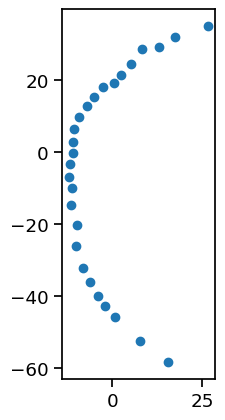

In [10]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts)
ax.set_aspect("equal")
...;

In [11]:
confitti.init_conic_from_xy(xpts, ypts)

{'x0': -1.6675094449599965,
 'y0': -4.982465997685019,
 'r0': 10.780427564822698,
 'theta0': 172.58418997570664,
 'eccentricity': 1.0}

## Fit the arc

In [12]:
result_p = confitti.fit_conic_to_xy(xpts, ypts, only_parabola=True)
result_e = confitti.fit_conic_to_xy(
    xpts, ypts, only_parabola=False, restrict_xy=True, restrict_theta=False
)

In [13]:
result_p

In [14]:
result_e

In [15]:
beste_xy = confitti.XYconic(**result_e.params.valuesdict())
print(beste_xy)
bestp_xy = confitti.XYconic(**result_p.params.valuesdict())
print(bestp_xy)

Conic section curve with focus at (65.37261159816535, -33.07345755578463), scale factor 28.81868663802626, angle -34.60019678236403, and eccentricity 0.49344723385371836.
Conic section curve with focus at (5.761920739590889, -1.2495512045284374), scale factor 17.288407072422736, angle 161.254672152365, and eccentricity 1.0.


/Users/will/Dropbox/confitti/src/confitti/confitti.py:143: RuntimeWarning: divide by zero encountered in divide
  self.r0


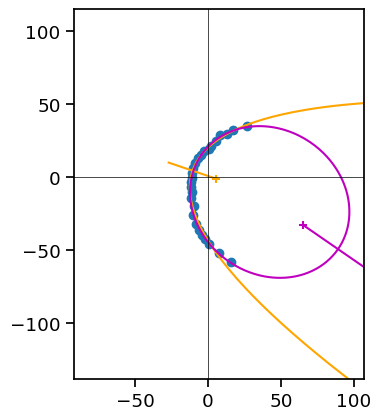

In [16]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts)

for xy, c in [[bestp_xy, "orange"], [beste_xy, "m"]]:
    ax.plot(xy.x_pts, xy.y_pts, color=c)
    ax.scatter(xy.x0, xy.y0, marker="+", color=c)
    ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color=c)

ax.axhline(0, lw=0.5, c="k")
ax.axvline(0, lw=0.5, c="k")
ax.set_aspect("equal")
margin = 80
ax.set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [17]:
fig.savefig(figpath / f"{saveprefix}-best-fits.pdf", bbox_inches="tight")

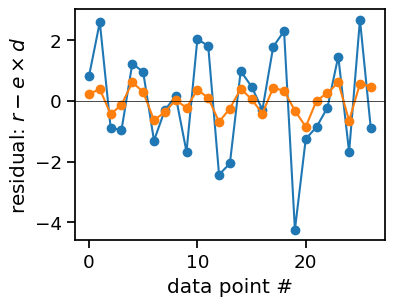

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(result_p.residual, "-o")
ax.plot(result_e.residual, "-o")
ax.axhline(0, color="k", lw=0.5)
ax.set(
    xlabel="data point #",
    ylabel=r"residual: $r - e \times d$",
)
...;

In [19]:
fig.savefig(figpath / f"{saveprefix}-residuals.pdf", bbox_inches="tight")

## Calculate posterior probability of parameters with emcee



In [20]:
emcee_kws = dict(
    steps=5000,
    burn=1000,
    thin=20,
    is_weighted=False,
    progress=False,
    workers=16,
    nan_policy="omit",
)
emcee_params = result_e.params.copy()
emcee_params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(1.0))

In [21]:
result_emcee = lmfit.minimize(
    confitti.residual,
    args=(xpts, ypts),
    method="emcee",
    params=emcee_params,
    **emcee_kws,
)

/Users/will/Dropbox/confitti/.venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [171.63492874 136.56536552 133.75708369 178.59335126 126.36311094
 103.56198641]


In [22]:
result_emcee

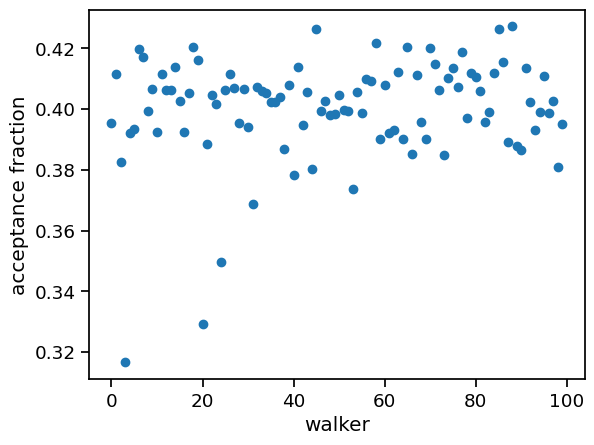

In [23]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")
plt.show()

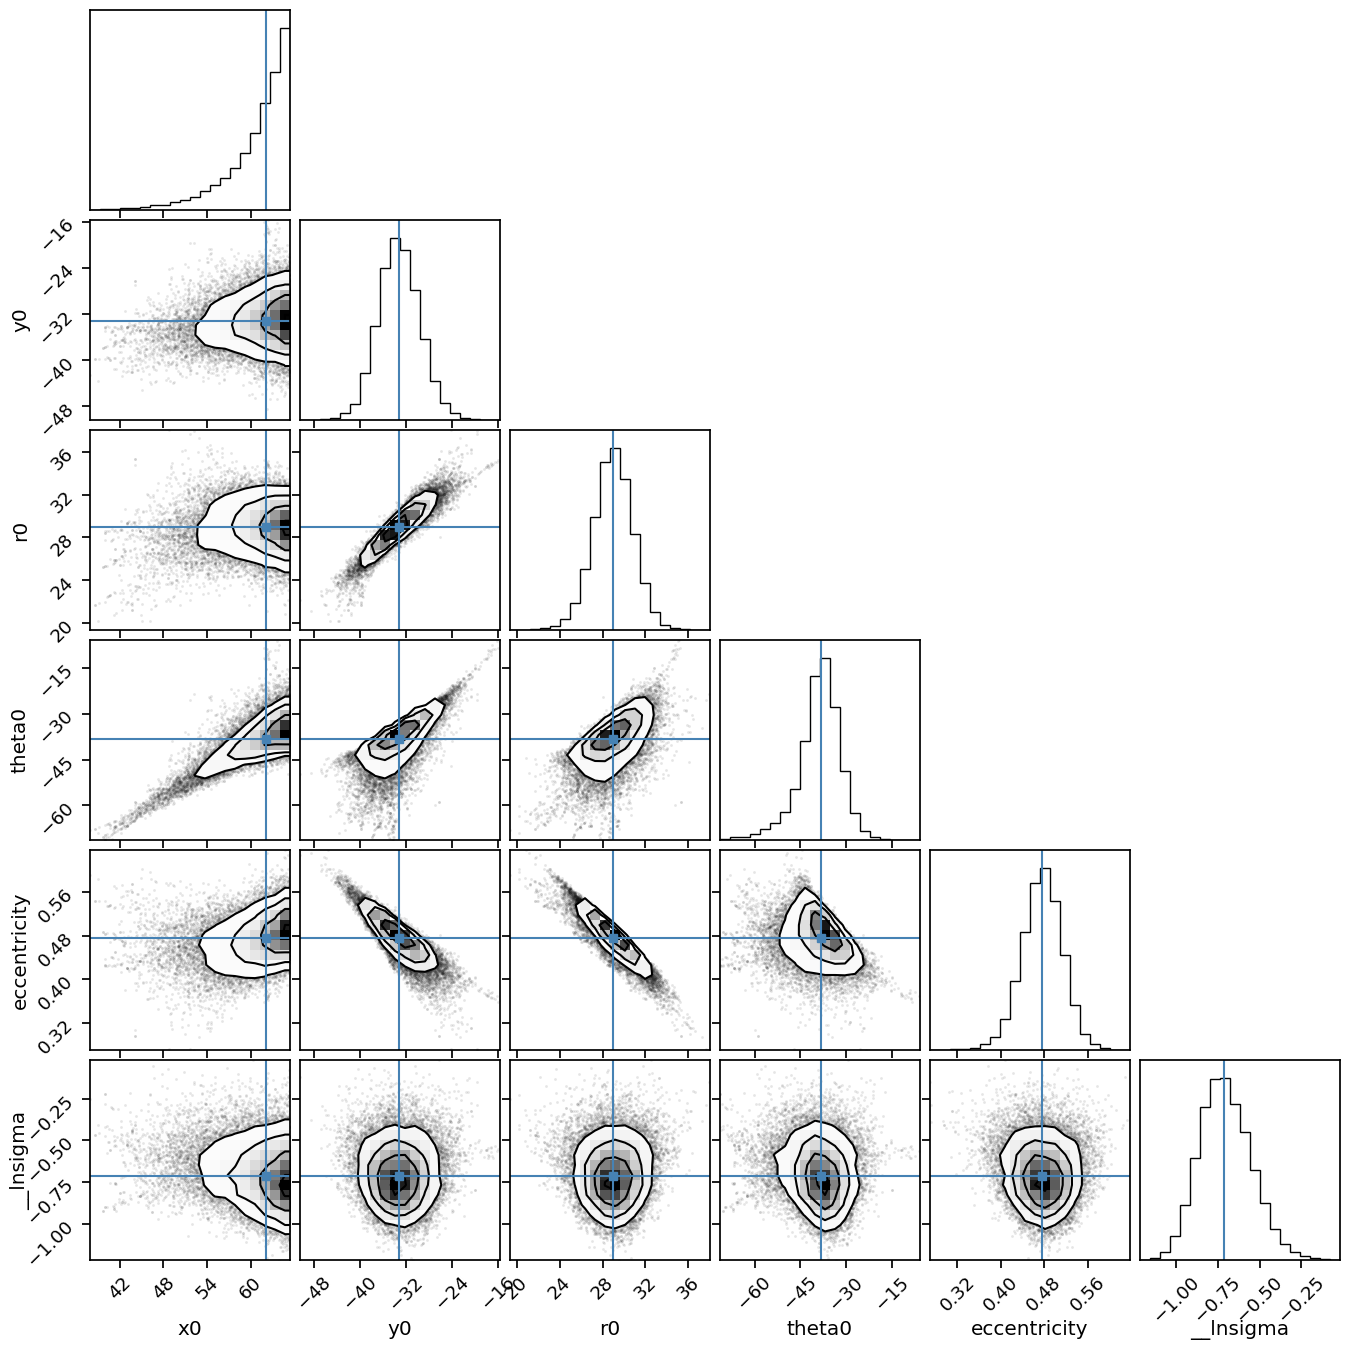

In [24]:
import corner

emcee_plot = corner.corner(
    result_emcee.flatchain,
    labels=result_emcee.var_names,
    truths=list(result_emcee.params.valuesdict().values()),
)

In [25]:
emcee_plot.savefig(figpath / f"{saveprefix}-corner.pdf", bbox_inches="tight")

In [26]:
best_xy = confitti.XYconic(**result_e.params.valuesdict())
chain_pars = result_emcee.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
chain_xy = [confitti.XYconic(**row) for row in chain_pars[7::200]]

In [27]:
len(chain_xy)

100

In [28]:
import matplotlib as mpl

In [29]:
cmap = mpl.cm.rainbow

In [30]:
eparam = result_emcee.params["eccentricity"]
# emin, emax = eparam.value - 2 * eparam.stderr, eparam.value + 2 * eparam.stderr
emin, emax = np.percentile(result_emcee.flatchain["eccentricity"], [5, 95])
norm = mpl.colors.Normalize(vmin=emin, vmax=emax)
norm(1.0)

4.80815797157562

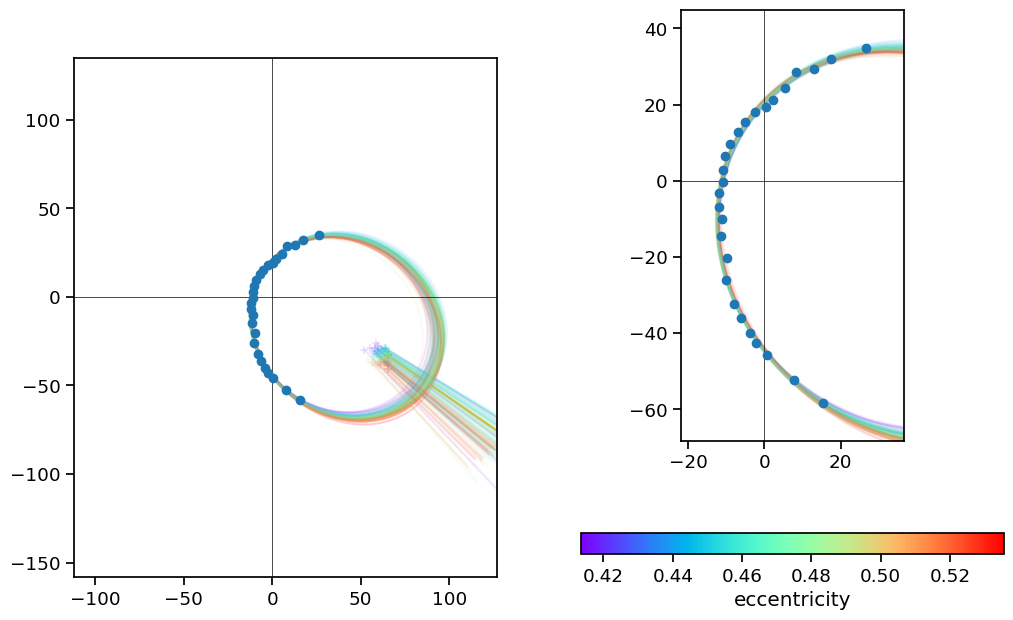

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for ax in axes:
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.1
    for xy in chain_xy:
        c = cmap(norm(xy.eccentricity))
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color=c, alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color=c, alpha=alpha)
    ax.scatter(xpts, ypts, zorder=1000)
    ax.axhline(0, lw=0.5, c="k")
    ax.axvline(0, lw=0.5, c="k")
    ax.set_aspect("equal")

margin = 100
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 10
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes[1],
    orientation="horizontal",
    label="eccentricity",
)
...;

In [32]:
fig.savefig(figpath / f"{saveprefix}-emcee-samples.pdf", bbox_inches="tight")

## Save results

This time, we will save the initial parabola fit (eccentricity = 1), just to be different from the last time (demo03), where we had saved the emcee fit with freely varing eccentricity. 

In [33]:
fit_result = confitti.ConicFitResult(result_p)

/Users/will/Dropbox/confitti/src/confitti/confitti.py:143: RuntimeWarning: divide by zero encountered in divide
  self.r0


In [34]:
fit_result.write(saveprefix + "-fit-result.yaml")

## Execution time for notebook

In [35]:
print(f"--- {time.time() - start_time} seconds ---")

--- 62.51863503456116 seconds ---
